In [1]:
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time

In [2]:
rootfolder = '..'

Useful function for plot the 2D DCT dictionary

In [3]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [4]:
def OMP(s, D, L, tau):
    D = D / np.linalg.norm(D, axis=0, keepdims=True)
    M, N = D.shape
    r = s.copy()
    x = np.zeros(N)
    omega = []
    while np.linalg.norm(r) > tau and np.nonzero(x)[0].size < L:
        j = np.argmax(np.abs(np.dot(D.T, r)))
        omega.append(j)
        x_omega = np.linalg.lstsq(D[:, omega], s, rcond=None)[0]
        x = np.zeros(N)
        x[omega] = x_omega
        r = s - np.dot(D, x)
    return x

Load the image and rescale it in $[0,1]$

(512, 512)

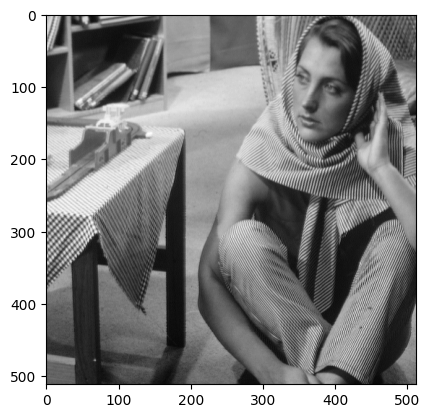

In [5]:
# img = plt.imread(f'{rootfolder}/data/cameraman.png')
img = plt.imread(f'{rootfolder}/data/barbara.png')
# img = plt.imread(f'{rootfolder}/data/Lena512.png')

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2

plt.imshow(img, cmap='gray');
imsz

Extract a bunch of random patches from the image

In [6]:
npatch = 5000

ii = np.random.choice(imsz[0] - p, npatch)
jj = np.random.choice(imsz[1] - p, npatch)

S = np.zeros((M, npatch))
for idx in range(npatch):
    S[:, idx] = img[ii[idx]:ii[idx] + p, jj[idx]:jj[idx] + p].flatten()

Remove the mean from the patches (each column of $S$ must have zero-mean)

In [7]:
S = S - np.mean(S, axis=0, keepdims=True)

Initialize the dictionary and the coefficient matrix

In [8]:
# number of columns of the dictionary
N = 256

# intialize the dictionary
D = np.random.randn(M, N)

# normalize each column of D (zero mean and unit norm)
D = D - np.mean(D, axis=0, keepdims=True)
D = D / np.linalg.norm(D, axis=0, keepdims=True)

# number of iteration of the KSVD
max_iter = 10

# maximum number of nonzero coefficients for the sparse coding
L = 4

# initialize the coefficient matrix
X = np.zeros((N, npatch))

Main KSVD loop


In [9]:
for iter in range(max_iter):
    time_start = time.time()
    print(f'iter {iter}')
    # perform the sparse coding via OMP of all the columns of S
    for n in range(npatch):
        X[:, n] = OMP(S[:, n], D, L, 0)
    
    # iterate over the columns of D
    for j in range(N):
        # find which signals uses the j-th atom in the sparse coding
        omega = np.nonzero(X[j, :])[0]

        if len(omega) == 0:
            # if the atom is never used then ignore or substitute it with a random vector
            continue
        else:
            # compute the residual matrix E, ignoring the j-th atom
            E = S - np.dot(D, X) + np.outer(D[:, j], X[j, :])

            # restrict E to the columns indicated by omega
            Eomega = E[:, omega]

            # compute the SVD of Eomega
            U, Sigma, VT = np.linalg.svd(Eomega, full_matrices=False)

            # update the dictionary
            D[:, j] = U[:, 0]

            # update the coefficient matrix
            X[j, omega] = Sigma[0] * VT[0]
    
    time_end = time.time()
    print(f'{time_end - time_start:.0f}')


iter 0
2
iter 1
2
iter 2
2
iter 3
2
iter 4
2
iter 5
2
iter 6
2
iter 7
2
iter 8
2
iter 9
2


Show the learned dictionary

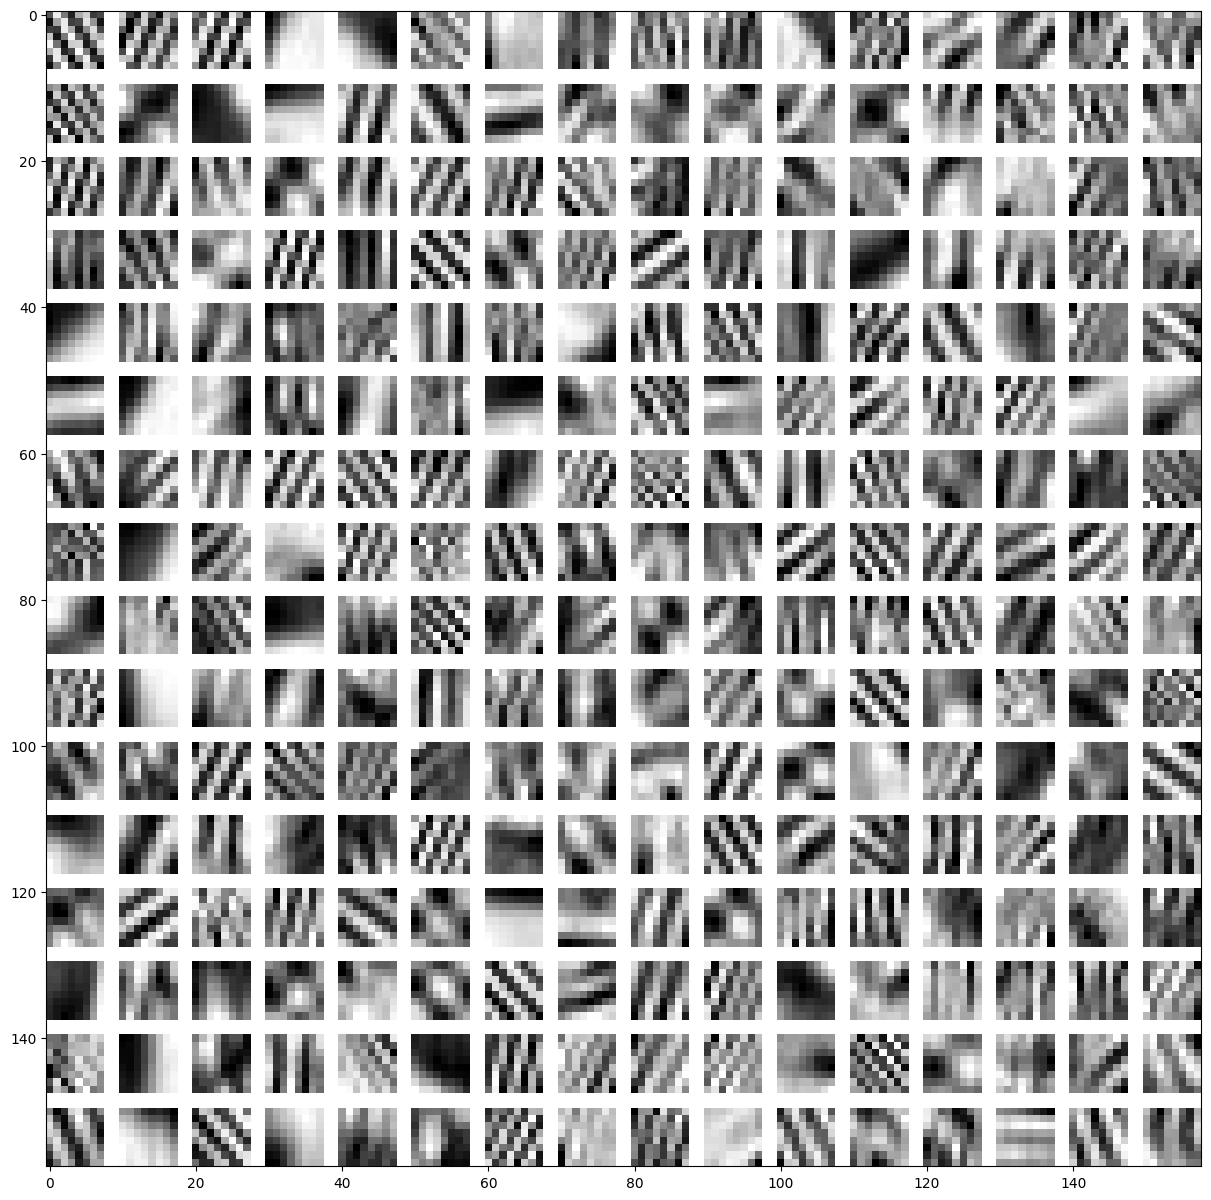

In [11]:
img_dict = get_dictionary_img(D)
plt.figure(figsize=(15, 15))
plt.imshow(img_dict, cmap='gray');